# 01 Setup

In [17]:
!pip install medvqa -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
# Install required libraries
!pip install --upgrade pip
!pip install "wandb>=0.15"
!pip install datasets evaluate rouge_score transformers einops timm peft
!pip install "accelerate>=0.26.0"
!pip install python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 262.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 369.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0 0/14 [typing-extensions]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [wandb]m13/14 [wandb]hon]]
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 387.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 369.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 318.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install "typing_extensions>=4.6.0" --upgrade --force-reinstall
!pip install --upgrade Pillow
import os
os.kill(os.getpid(), 9)  # This restarts the runtime

  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.13.2-py3-none-any.whl (45 kB)
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.13.2
    Uninstalling typing_extensions-4.13.2:
      Successfully uninstalled typing_extensions-4.13.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 161.9 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0


# 02 Load Dataset, Model

In [1]:
from huggingface_hub import login
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path="secrets.env")
hf_token = os.getenv("HF_TOKEN")

login(token=hf_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
# Import necessary modules
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoProcessor, Trainer, TrainingArguments
import torch
from peft import get_peft_model, LoraConfig, TaskType

MODEL_NAME = "microsoft/Florence-2-base-ft"

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Florence-2 model
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, trust_remote_code=True)

# <-- Apply LoRA adaptation on top of base model
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "lm_head", "fc2"],
    task_type=TaskType.CAUSAL_LM,
    lora_dropout=0.05478,
    bias="none",
    inference_mode=False,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
model = model.to(device)

# Load processor
processor = AutoProcessor.from_pretrained(MODEL_NAME, trust_remote_code=True)

# total_params = sum(p.numel() for p in model.parameters())
# print(f'total parameters: {total_params}')

# # Freeze vision tower
# for param in model.vision_tower.parameters():
#     param.requires_grad = False
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f'trainable parameters: {trainable_params} {trainable_params/total_params:.2f}')

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise y

trainable params: 3,859,856 || all params: 274,663,824 || trainable%: 1.4053


In [3]:
# Load dataset
DATASET_COVERAGE = 1
SEED = 7
TEST_SIZE = 0.1

ds = load_dataset("SimulaMet-HOST/Kvasir-VQA")['raw']

if DATASET_COVERAGE < 1:
    dataset = ds.train_test_split(test_size=DATASET_COVERAGE, seed=SEED, shuffle=True)
    dataset = dataset['test'].train_test_split(test_size=TEST_SIZE, seed=SEED)
    train_dataset, val_dataset = dataset['train'], dataset['test']
else:
    dataset = ds.train_test_split(test_size=TEST_SIZE, seed=SEED)
    train_dataset, val_dataset = dataset['train'], dataset['test']

train_dataset.shape, val_dataset.shape, train_dataset.shape[0] + val_dataset.shape[0], ds.shape

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

((52964, 5), (5885, 5), 58849, (58849, 5))

In [4]:
def collate_fn(batch):
    questions = [f"{x['question']}" for x in batch]
    images = [x["image"].convert("RGB") if x["image"].mode != "RGB" else x["image"] for x in batch]
    answers = [x["answer"] for x in batch]

    inputs = processor(text=questions, images=images, return_tensors="pt", padding=True)
    labels = processor.tokenizer(answers, return_tensors="pt", padding=True).input_ids
    labels[labels == processor.tokenizer.pad_token_id] = -100
    inputs["labels"] = labels
    return inputs

# 03 Error Metrics

In [5]:
# (optional) if you want to evaluate with NLP or other metrics
import evaluate
import numpy as np

bleu, meteor, rouge = map(evaluate.load, ["bleu", "meteor", "rouge"])

# def compute_metrics(eval_pred):
#     preds, labels = eval_pred
#     preds = processor.tokenizer.batch_decode(np.argmax(preds[0], axis=-1), skip_special_tokens=True)
#     labels = processor.tokenizer.batch_decode(np.where(labels != -100, labels, processor.tokenizer.pad_token_id), skip_special_tokens=True)
#     preds, labels = [p.strip() for p in preds], [l.strip() for l in labels]

#     return {
#         # "bleu": bleu.compute(predictions=preds, references=[[l] for l in labels])["bleu"],
#         # "meteor": meteor.compute(predictions=preds, references=labels)["meteor"],
#         "rougeL": rouge.compute(predictions=preds, references=labels)["rougeL"],
#     }

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
import wandb
wandb.login()

wandb: Currently logged in as: parajuligaurav007 (MedPixel) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
import math

# ==== Hyperparameters ====
MODEL_NAME = 'florence2'
TRAIN_DATASET_SIZE = len(train_dataset)

PER_DEVICE_TRAIN_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 16
PER_DEVICE_EVAL_BATCH_SIZE = 4
EVAL_ACCUMULATION_STEPS = 1
BASE_LEARNING_RATE = 9.6e-5
WEIGHT_DECAY = 0.07

NUM_EPOCHS = 5
LOGGING_STEPS = 10

# ==== Derived Values ====
effective_batch_size = PER_DEVICE_TRAIN_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS
scaled_learning_rate = BASE_LEARNING_RATE * math.sqrt((effective_batch_size / 20))
steps_per_epoch = math.ceil(TRAIN_DATASET_SIZE / effective_batch_size)
max_steps = steps_per_epoch * NUM_EPOCHS

run_name = f"{MODEL_NAME}_{effective_batch_size}_r16"

# ==== Training Arguments ====
training_args = TrainingArguments(
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=f"gauravparajuli/{run_name}",
    # output_dir="./Florence-2-vqa",
    output_dir=run_name,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    eval_accumulation_steps=EVAL_ACCUMULATION_STEPS,
    max_steps=max_steps,
    learning_rate=BASE_LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    logging_steps=LOGGING_STEPS,
    save_strategy="steps",
    save_steps=steps_per_epoch,  # once per epoch
    eval_strategy="steps",
    eval_steps=steps_per_epoch,  # once per epoch
    report_to="wandb",
    save_total_limit=3,
    remove_unused_columns=False,
    fp16=True,
    load_best_model_at_end=True,  # <-- Save best model automatically
    # metric_for_best_model="rougeL",
    greater_is_better=True
)

print(f'num epochs: {NUM_EPOCHS}')
print('base learning rate: ', BASE_LEARNING_RATE)
print(run_name)

num epochs: 5
base learning rate:  9.6e-05
florence2_64_r16


In [8]:
import wandb
import shutil
from transformers import EarlyStoppingCallback

wandb.init(
    project="ImageClef2025VQA",
    name=run_name,  # same run_name you're using above
    config={
        "batch_size": PER_DEVICE_TRAIN_BATCH_SIZE,
        "grad_acc_steps": GRADIENT_ACCUMULATION_STEPS,
        "effective_batch_size": effective_batch_size,
        "base_learning_rate": BASE_LEARNING_RATE,
        "num_epochs": NUM_EPOCHS,
    }
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    # compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     data_collator=collate_fn,
#     compute_metrics=compute_metrics # if you want to evaluate with NLP or other metrics (optional)
# )

trainer.train()
wandb.finish()
shutil.rmtree(training_args.output_dir)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
828,0.133000,0.104356
1656,0.085200,0.092912
2484,0.078600,0.084372
3312,0.101600,0.081446
4140,0.089400,0.079237


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:220: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:220: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:220: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:220: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

eval/loss,█▅▂▂▁
eval/runtime,▅▆▁██
eval/samples_per_second,▄▃█▁▁
eval/steps_per_second,▄▃█▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇████
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train/grad_norm,█▄▄▄▂▄▆▁▃▃▁█▂▄▂▄▄▂▂▂▁█▃▅▁▃▃▂▃▄▃▃▄▄▄▃▂▁▄▁
train/learning_rate,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
train/loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.07924
eval/runtime,573.4103


# Inference

Q: Is there a green/black box artefact?
Model: no
GT: no


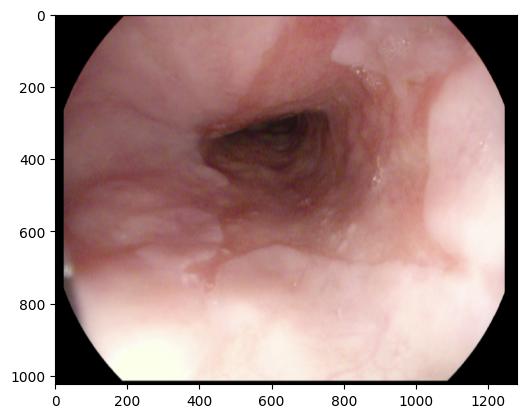

In [11]:
# ReRun this block to generate for new ramdom sample
import random
sample = [val_dataset[random.randint(0, len(val_dataset)-1)]] # rerun this block to generate new sample
import matplotlib.pyplot as plt; plt.imshow(sample[0]['image'])
inputs = collate_fn(sample)
inputs = {k: v.to(device) for k, v in inputs.items() if k not in ['labels', 'attention_mask']}

with torch.no_grad():
    output = model.generate(**inputs)

print(f"Q: {sample[0]['question']}\nModel: {processor.tokenizer.decode(output[0], skip_special_tokens=True)}\nGT: {sample[0]['answer']}")